In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import altair as alt
alt.data_transformers.disable_max_rows()
import datetime as dt
import numpy as np
from metpy.units import units
import pandas as pd
import rioxarray as rix

In [2]:
fn = "/Users/elischwat/Development/data/sublimationofsnow/lidar_rasters/l2_test_20230505_20230530_hourly.nc"

In [3]:
ds_lazy = xr.open_dataset(fn, chunks={
    'time': 1, 'x': 1000, 'y':1000
})

In [4]:
init_condition = ds_lazy.sel(
    # x = slice(-16, 26),
    # y = slice(-20, 16)
).sel(time = '20230505 0000')['surface']

In [5]:
# for date_str in [
#     '20230506 0000',
#     '20230507 0000',
#     '20230508 0000',
#     '20230509 0000',
#     '20230510 0000',
#     '20230511 0000',
#     '20230512 0000',
#     '20230513 0000',
#     '20230514 0000',
#     '20230515 0000',
#     '20230516 0000',
#     '20230517 0000',
#     '20230518 0000',
#     '20230519 0000',
#     '20230520 0000',
#     '20230521 0000',
#     '20230522 0000',
#     '20230523 0000',
# ]:
#     (ds_lazy.sel(
#         # x = slice(-16, 26),
#         # y = slice(-20, 16)
#     ).sel(time = date_str)['surface'] - init_condition).plot(vmin=-2, vmax=0, cmap='Reds_r')
#     plt.title(date_str)
#     plt.show()

In [6]:
ds_lazy.time[-1], ds_lazy.time[0]

(<xarray.DataArray 'time' ()> Size: 8B
 array('2023-05-30T23:00:00.000000000', dtype='datetime64[ns]')
 Coordinates:
     time     datetime64[ns] 8B 2023-05-30T23:00:00,
 <xarray.DataArray 'time' ()> Size: 8B
 array('2023-05-05T00:00:00.000000000', dtype='datetime64[ns]')
 Coordinates:
     time     datetime64[ns] 8B 2023-05-05)

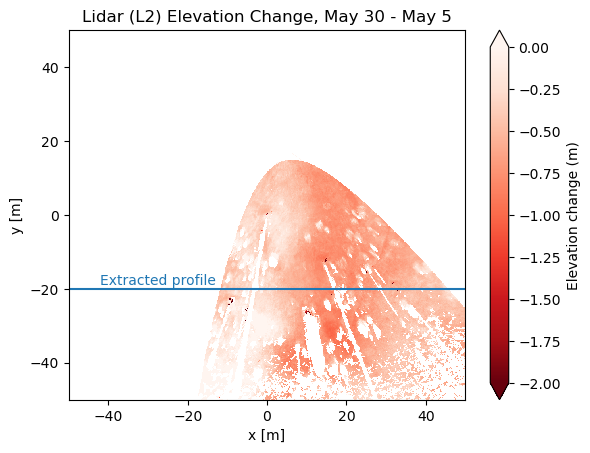

In [7]:
(
    ds_lazy.sel(time = ds_lazy.time[-1])['surface'] 
    - ds_lazy.sel(time = ds_lazy.time[0])['surface']
).plot(vmin=-2, vmax=0, cmap='Reds_r', cbar_kwargs={'label': 'Elevation change (m)'})
plt.title('Lidar (L2) Elevation Change, May 30 - May 5')
plt.axhline(-20)
plt.text(-42, -19, "Extracted profile", color='tab:blue')  # Add text at x=-20, y=-20
plt.show()

In [8]:
ds_diff_lazy = ds_lazy.sel(time = slice(ds_lazy.time[1],  None)) - ds_lazy.sel(time = ds_lazy.time[0])

In [9]:
src1 = ds_lazy.interp(y = -8).sel(
    time = slice('20230517 0600', '20230517 1700'),
    x = slice(10,21)
).surface
src1_df = src1.to_dataframe().dropna().reset_index().dropna()
src1_df = src1_df.groupby('time').apply(
    lambda df: df.set_index('x')[['surface']].rolling(10, center=True).median()
).reset_index().query("x > 12").query("x < 20")
diff_0500_1200 = alt.Chart(
    src1_df
).mark_line().encode(
    alt.X('x:Q'),
    alt.Y('mean(surface):Q').title('Elevation (m)').scale(domain=[-12.5,-12]),
    alt.Color('hours(time):O').scale(scheme='turbo').legend(columns=2),
    tooltip = 'time:O',
).properties(title = 'Lidar Absolute Elevation (vertically exagerated by 2x)', width=800, height=100, )
diff_0500_1200


/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_60724/1587595423.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  src1_df = src1_df.groupby('time').apply(


alt.Chart(...)

fit a sigmoid one day at one x value

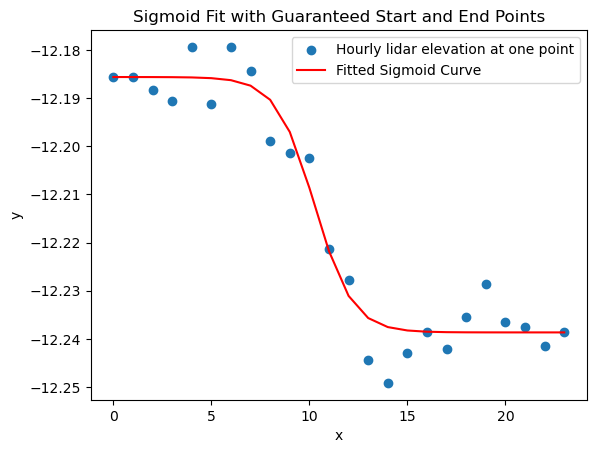

In [28]:
from scipy.optimize import curve_fit

src1_sigmoided = ds_lazy.interp(y = -8).sel(
    time = slice('20230517 0000', '20230517 2359'),
    x = slice(10,21)
).surface.interp(x=14.5)
x_data=pd.Series(src1_sigmoided.time.values).index
y_data=src1_sigmoided.values

def sigmoid_constrained(x, k, x0, y1, yn):
    return (yn - y1) / (1 + np.exp(-k * (x - x0))) + y1
# Initial guesses for the parameters k and x0
# A good guess for x0 is often the midpoint of the x-range

y1_fixed = y_data[0]
yn_fixed = y_data[-1]
initial_guess = [1.0, np.median(x_data)]

# Use lambda to create a function with fixed y1 and yn
params, _ = curve_fit(
    lambda x, k, x0: sigmoid_constrained(x, k, x0, y1_fixed, yn_fixed),
    x_data, y_data, p0=initial_guess
)

k_fit, x0_fit = params
# Generate the fitted curve
x_fit = np.linspace(x_data[0], x_data[-1], len(y_data))
y_fit = sigmoid_constrained(x_fit, k_fit, x0_fit, y1_fixed, yn_fixed)

# Plot the results
plt.scatter(x_data, y_data, label='Hourly lidar elevation at one point')
plt.plot(x_fit, y_fit, 'r-', label='Fitted Sigmoid Curve')
plt.title('Sigmoid Fit with Guaranteed Start and End Points')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [81]:
src1_sigmoided = src1_sigmoided.copy(data=y_fit)

In [82]:

src1 = src1_sigmoided.diff('time').to_dataframe().dropna().reset_index().dropna()
mm_hr = src1.surface
snowmelt_m_per_s = mm_hr / (60*60)
snow_density = 430 * units("kg/m^3")
specific_heat_of_fusion = 334 * units("kJ/kg")

melt_energy = (   
    (
        snowmelt_m_per_s.values * units("m^3/s") * snow_density * specific_heat_of_fusion
    ) / (1*units("m^2"))
).to("W/m^2")
src1['melt_energy'] = melt_energy.magnitude

alt.Chart(src1).mark_circle(size=75).encode(
    alt.X('time:T'),
    alt.Y('mean(melt_energy):Q')
)+ alt.Chart(src1).mark_rule(color='#1f77b4').encode(
    alt.X('time:T'),
    alt.Y('q1(melt_energy):Q'),
    alt.Y2('q3(melt_energy):Q')
) + alt.Chart(src1).mark_line().encode(
    alt.X('time:T'),
    alt.Y('mean(melt_energy):Q')
) 

alt.LayerChart(...)

In [83]:
src1 = ds_lazy.interp(y = -8).sel(
    time = slice('20230517 0000', '20230517 2359'),
    x = slice(14,19)
).surface
src1 = src1.diff('time').to_dataframe().dropna().reset_index().dropna()
mm_hr = src1.surface
snowmelt_m_per_s = mm_hr / (60*60)
snow_density = 430 * units("kg/m^3")
specific_heat_of_fusion = 334 * units("kJ/kg")

melt_energy = (   
    (
        snowmelt_m_per_s.values * units("m^3/s") * snow_density * specific_heat_of_fusion
    ) / (1*units("m^2"))
).to("W/m^2")
src1['melt_energy'] = melt_energy.magnitude

alt.Chart(src1).mark_circle(size=75).encode(
    alt.X('time:T'),
    alt.Y('mean(melt_energy):Q')
)+ alt.Chart(src1).mark_rule(color='#1f77b4').encode(
    alt.X('time:T'),
    alt.Y('q1(melt_energy):Q'),
    alt.Y2('q3(melt_energy):Q')
) + alt.Chart(src1).mark_line().encode(
    alt.X('time:T'),
    alt.Y('mean(melt_energy):Q')
) 

alt.LayerChart(...)

In [84]:
src1 = ds_lazy.interp(y = -8).sel(
    time = slice('20230515 0000', '20230517 2359'),
    x = slice(14,19)
).surface
src1 = src1.diff('time').to_dataframe().dropna().reset_index().dropna()
mm_hr = src1.surface
snowmelt_m_per_s = mm_hr / (60*60)
snow_density = 430 * units("kg/m^3")
specific_heat_of_fusion = 334 * units("kJ/kg")

melt_energy = (   
    (
        snowmelt_m_per_s.values * units("m^3/s") * snow_density * specific_heat_of_fusion
    ) / (1*units("m^2"))
).to("W/m^2")
src1['melt_energy'] = melt_energy.magnitude

alt.Chart(src1).mark_circle(size=75).encode(
    alt.X('time:T'),
    alt.Y('mean(melt_energy):Q')
)+ alt.Chart(src1).mark_rule(color='#1f77b4').encode(
    alt.X('time:T'),
    alt.Y('q1(melt_energy):Q'),
    alt.Y2('q3(melt_energy):Q')
) + alt.Chart(src1).mark_line().encode(
    alt.X('time:T'),
    alt.Y('mean(melt_energy):Q')
) 

alt.LayerChart(...)

# Energy balance calculations

Gather the data we need - from SOS and SPLASH

In [85]:
from sublimpy import variables, utils, tidy

In [86]:
sos_tidy_fn = f"../../paper1/process_slow_data/tidy_df_20221101_20230619_planar_fit_multiplane_q7_flags9000_pf10.parquet"
sos_df = pd.read_parquet(sos_tidy_fn)
sos_df['time'] = pd.to_datetime(sos_df['time'])
sos_df = utils.modify_df_timezone(sos_df, 'UTC', 'US/Mountain')

In [87]:
kps_download_dir = "/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-30_Level2_SPLASH2021-2023/"

print('Starting dask client')
from dask.distributed import Client
client = Client(n_workers=10, threads_per_worker=2, memory_limit='10GB')

kps_file_list = sorted([
    os.path.join(kps_download_dir, f) for f in os.listdir(kps_download_dir) 
    if 'sledseb.asfs30.level2.0.10min.' in f
])[385:]
kps_file_list[0], kps_file_list[-1]

kpsann_ds_lazy = xr.open_mfdataset(
    kps_file_list, combine='nested', concat_dim='time', compat='override', coords='all', parallel=True
)
kpsann_df = kpsann_ds_lazy[[
    'time', 'temp', 'atmos_pressure',  'skin_temp_surface',
    'down_long_hemisp', 'up_long_hemisp', 'down_short_hemisp', 'up_short_hemisp',
]].to_dask_dataframe().compute()
kpsann_df_30min = kpsann_df.set_index('time').resample('30min').mean()

print('Closing dask client')
client.shutdown()
#### Step 2
# open up SOS 5min datasets
files = [
    "/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_isfs_qc_geo_tiltcor_5min_v20241227/isfs_sos_qc_geo_tiltcor_5min_v2_20230512.nc",
    "/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_isfs_qc_geo_tiltcor_5min_v20241227/isfs_sos_qc_geo_tiltcor_5min_v2_20230513.nc",
    "/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_isfs_qc_geo_tiltcor_5min_v20241227/isfs_sos_qc_geo_tiltcor_5min_v2_20230514.nc",
    "/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_isfs_qc_geo_tiltcor_5min_v20241227/isfs_sos_qc_geo_tiltcor_5min_v2_20230515.nc",
    "/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_isfs_qc_geo_tiltcor_5min_v20241227/isfs_sos_qc_geo_tiltcor_5min_v2_20230516.nc",
    "/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_isfs_qc_geo_tiltcor_5min_v20241227/isfs_sos_qc_geo_tiltcor_5min_v2_20230517.nc",
    "/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_isfs_qc_geo_tiltcor_5min_v20241227/isfs_sos_qc_geo_tiltcor_5min_v2_20230518.nc",
    "/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_isfs_qc_geo_tiltcor_5min_v20241227/isfs_sos_qc_geo_tiltcor_5min_v2_20230519.nc",
    "/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_isfs_qc_geo_tiltcor_5min_v20241227/isfs_sos_qc_geo_tiltcor_5min_v2_20230520.nc",
    "/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_isfs_qc_geo_tiltcor_5min_v20241227/isfs_sos_qc_geo_tiltcor_5min_v2_20230521.nc",
    "/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_isfs_qc_geo_tiltcor_5min_v20241227/isfs_sos_qc_geo_tiltcor_5min_v2_20230522.nc",
]
datasets = [xr.open_dataset(file) for file in files]
sos_ds = xr.concat(datasets, dim='time')

# gather the variables we need for surface temp calculations and resample to 30min
sos_ds = sos_ds[[
    'Rpile_in_9m_d', 'Tcase_in_9m_d', 'Rpile_out_9m_d', 'Tcase_out_9m_d', 
    'Rpile_in_uw', 'Tcase_uw', 'Rpile_out_uw', 'Tcase_uw', 
    'IDir_c', 'IDir_d', 'IDir_uw', 'IDir_ue', 'Vtherm_c', 
    'Vtherm_d', 'Vtherm_uw', 'Vtherm_ue', 'Vpile_c', 'Vpile_d', 'Vpile_uw', 'Vpile_ue', 
]].resample(time='30min').mean()

# gather the SPLASH KPS-Annex measurements of Rlw_in
kpsann_down_long_hemisp = kpsann_df.set_index('time')[[
    'down_long_hemisp', 'up_long_hemisp', 'down_short_hemisp', 'up_short_hemisp',
]].to_xarray().sel(
    time = slice(sos_ds.time.values.min(), sos_ds.time.values.max())
).resample(time='30min').mean()

# add the KPS-Annex Rlw_in to the SOS dataset
sos_ds['Rlw_in_9m_d'] = kpsann_down_long_hemisp['down_long_hemisp']
sos_ds['Rlw_out_9m_d'] = kpsann_down_long_hemisp['up_long_hemisp']
sos_ds['Rsw_in_9m_d'] = kpsann_down_long_hemisp['down_short_hemisp']
sos_ds['Rsw_out_9m_d'] = kpsann_down_long_hemisp['up_short_hemisp']
new_variables = [
        'Tsurf_c', 'Tsurf_d', 'Tsurf_uw', 'Tsurf_ue',
         'Rlw_in_9m_d', 'Rlw_out_9m_d', 'Rsw_in_9m_d', 'Rsw_out_9m_d'
    ]
sos_ds = variables.add_surface_temps(sos_ds)[new_variables]
sos_ds = utils.modify_xarray_timezone(sos_ds, 'UTC', 'US/Mountain')
# combine the datasets
sos_df_gapfilled = pd.concat([
    sos_df[ ~ sos_df.variable.isin(new_variables)],
    tidy.get_tidy_dataset(sos_ds, variable_names=new_variables)
])
sos_df = sos_df_gapfilled.set_index('time').sort_index().reset_index()
sos_df

Starting dask client


2025-10-20 12:44:21,581 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:64138' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {'original-open_dataset-up_short_hemisp-7a63ef55a1b0530d52582a598763f40e', 'original-open_dataset-down_long_hemisp-036dec386c86a68dbe31d3b5ca041a82', 'original-open_dataset-temp-8222800de86691d0660e175b27cddda1'} (stimulus_id='handle-worker-cleanup-1760989461.58113')
2025-10-20 12:44:21,590 - distributed.nanny - WARNING - Restarting worker


Closing dask client


,time,variable,value,height,tower,measurement
0,2022-10-31 18:00:00,counts_1m_c,36000.000000,1.0,c,eddy covariance momentum high rate count
1,2022-10-31 18:00:00,irgadiag_10m_c,0.000000,10.0,c,irgason diagnostic flag
2,2022-10-31 18:00:00,Tpot_2m_c,27.652222,2.0,c,potential temperature
3,2022-10-31 18:00:00,Tvirtual_2m_c,1.239136,2.0,c,virtual temperature
4,2022-10-31 18:00:00,Tpotvirtual_2m_c,301.339569,2.0,c,potential virtual temperature
...,...,...,...,...,...,...
9584251,2023-06-19 17:30:00,v_co2__10m_uw,-0.000599,10.0,uw,v_co2_
9584252,2023-06-19 17:30:00,Ri_2m_c,-0.062041,2.0,c,richardson number
9584253,2023-06-19 17:30:00,u_h2o__1m_d,-0.041972,1.0,d,u_h2o_
9584254,2023-06-19 17:30:00,Tpotvirtual_8m_c,321.238861,8.0,c,potential virtual temperature


Calculate terms

Net radiation

In [88]:
EST_ALBEDO = 0.6
net_rad_df = sos_df[sos_df.variable.isin([
    'Rsw_in_9m_d',
    'Rsw_out_9m_d',
    'Rlw_in_9m_d',
    'Rlw_out_9m_d',
])].pivot_table(index='time', columns='variable', values='value')

net_rad_df['Rsw_out_9m_d_modeled'] = EST_ALBEDO*net_rad_df['Rsw_in_9m_d']

net_rad_df['net radiation'] = (
    net_rad_df['Rsw_in_9m_d'] - net_rad_df['Rsw_out_9m_d_modeled'] 
    + net_rad_df['Rlw_in_9m_d'] - net_rad_df['Rlw_out_9m_d']
)
net_rad_df['albedo'] = net_rad_df['Rsw_out_9m_d_modeled'] / net_rad_df['Rsw_in_9m_d']
# net_rad_df = net_rad_df[['net radiation']]
net_rad_df.head(3)

variable,Rlw_in_9m_d,Rlw_out_9m_d,Rsw_in_9m_d,Rsw_out_9m_d,Rsw_out_9m_d_modeled,net radiation,albedo
time,,,,,,,
2023-05-11 18:00:00,319.446288,316.860304,140.464584,81.015864,84.278751,58.771818,0.6
2023-05-11 18:30:00,321.893480,316.331281,84.144969,49.041470,50.486982,39.220186,0.6
2023-05-11 19:00:00,318.319309,315.925871,49.286126,28.194171,29.571676,22.107889,0.6


Turbulent fluxes

In [89]:
turb_flux_df = sos_df[sos_df.variable.isin([
    'w_h2o__3m_c',
    'w_tc__3m_c'
])].pivot_table(index='time', columns='variable', values='value')

latent_heat_sublimation = 2838 #J/g
turb_flux_df['w_h2o__3m_c'] = - turb_flux_df['w_h2o__3m_c'] * latent_heat_sublimation

specific_heat_capacity_air = 1.005 # J/K/g
air_density = 1000 # g/m^3                                       
turb_flux_df['w_tc__3m_c'] = - turb_flux_df['w_tc__3m_c'] * specific_heat_capacity_air * air_density

turb_flux_df.head(3)

variable,w_h2o__3m_c,w_tc__3m_c
time,,
2022-10-31 18:00:00,-7.737561,26.781283
2022-10-31 18:30:00,-8.103559,26.646656
2022-10-31 19:00:00,-5.446743,24.788923


Melt energy, from snow pillows

In [90]:
# melt_energy_df = sos_df[sos_df.variable.isin([
#     'SWE_p2_c', 'SWE_p4_c', 
#     'SWE_p1_c', 'SWE_p3_c', 
# ])].set_index('time').sort_index().loc[
#     '20230512': '20230518'
# ].reset_index().pivot_table(
#     index = ['time', 'tower'],
#     values='value',
#     columns='measurement'
# ).reset_index()

# melt_energy_df.set_index('time').query("tower == 'c'").SWE.plot(label='c')
# melt_energy_df.set_index('time').query("tower == 'd'").SWE.plot(label='d')
# melt_energy_df.set_index('time').query("tower == 'ue'").SWE.plot(label='ue')
# melt_energy_df.set_index('time').query("tower == 'uw'").SWE.plot(label='uw')
# plt.ylabel('snow pillow swe (mm)')
# plt.legend()

In [63]:
# melt_energy_df.set_index('time').query("tower == 'uw'").SWE.plot()
# melt_energy_df.set_index('time').query("tower == 'd'").SWE.plot()

Combine

In [91]:
energy_balance_df = turb_flux_df.join(
    net_rad_df
)
energy_balance_df = energy_balance_df.loc['20230517']
energy_balance_df = energy_balance_df[[
    'net radiation', 
    'w_h2o__3m_c', 
    # 'w_tc__3m_c'
]].resample('60min').mean()

In [92]:
# energy_balance_df = energy_balance_df.join(melt_energy_df.set_index('time'))

In [93]:
energy_balance_df = energy_balance_df.join(
    src1.groupby('time')[['melt_energy']].mean()
    # src1.groupby('time')[['melt_energy']].mean().rolling(4).mean()
)

In [94]:
energy_balance_df['residual'] = energy_balance_df.sum(axis=1)

In [95]:
alt.Chart(
    energy_balance_df.reset_index()
).transform_fold([
    'net radiation',
    'w_h2o__3m_c',
    'melt_energy',
    'residual'
]).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
    alt.Color('key:N')
)

alt.Chart(...)

In [107]:
pd.DataFrame(energy_balance_df.loc['20230517 1200': '20230517 1300'].mean())

,0
net radiation,247.213130
w_h2o__3m_c,-146.470684
melt_energy,-382.887233
residual,-282.144787


In [104]:
pd.DataFrame(energy_balance_df.loc['20230517 0700': '20230517 1800'].mean())

,0
net radiation,152.982280
w_h2o__3m_c,-96.346006
melt_energy,-164.854424
residual,-108.218151


# Georeference the raster data (loosely).

0,0 in the dataset is the tower C location.

In [108]:
import geopandas as gpd

In [109]:
import geopandas as gpd
patch_outlines_gdf = gpd.read_file("/Users/elischwat/Downloads/snow_patch_outlines_starting_20230516.shp")

In [110]:
towers_gdf = gpd.read_file("../landsat_data/towers.geojson")
towers_gdf_utm = towers_gdf.to_crs("EPSG:32613")
towers_gdf_utm

,Tower,lat,lon,alt,geometry
0,uw,38.942033,-106.972967,2863,POINT (329010.876 4312194.793)
1,ue,38.941783,-106.973250,2861,POINT (328985.717 4312167.579)
2,d,38.941733,-106.972817,2861,POINT (329023.156 4312161.217)
3,c,38.941817,-106.972983,2861,POINT (329008.911 4312170.778)


In [111]:
ds_georef_lazy = ds_lazy.assign_coords(
    x = ds_lazy.x + towers_gdf_utm.set_index('Tower').loc['c']['geometry'].x,
    y = ds_lazy.y + towers_gdf_utm.set_index('Tower').loc['c']['geometry'].y
)

In [112]:
ds_georef_lazy.sel(time = '20230515 0000')['surface'].rio.set_crs('EPSG:32613').rio.to_raster(
    "l2_elevation_20230515_0000.tif"
)
ds_georef_lazy.sel(time = '20230516 0000')['surface'].rio.set_crs('EPSG:32613').rio.to_raster(
    "l2_elevation_20230516_0000.tif"
)
ds_georef_lazy.sel(time = '20230523 0000')['surface'].rio.set_crs('EPSG:32613').rio.to_raster(
    "l2_elevation_20230523_0000.tif"
)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_33378/3724031706.py:1: FutureWarning: It is recommended to use 'rio.write_crs()' instead. 'rio.set_crs()' will likelybe removed in a future release.
  ds_georef_lazy.sel(time = '20230515 0000')['surface'].rio.set_crs('EPSG:32613').rio.to_raster(
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_33378/3724031706.py:4: FutureWarning: It is recommended to use 'rio.write_crs()' instead. 'rio.set_crs()' will likelybe removed in a future release.
  ds_georef_lazy.sel(time = '20230516 0000')['surface'].rio.set_crs('EPSG:32613').rio.to_raster(
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_33378/3724031706.py:7: FutureWarning: It is recommended to use 'rio.write_crs()' instead. 'rio.set_crs()' will likelybe removed in a future release.
  ds_georef_lazy.sel(time = '20230523 0000')['surface'].rio.set_crs('EPSG:32613').rio.to_raster(


In [113]:
src = ds_georef_lazy['surface'].rio.set_crs('EPSG:32613')
mm_hr = src.rio.clip(patch_outlines_gdf.geometry, drop=True).diff('time')
mm_hr = mm_hr.sel(time=slice('20230515', '20230518'))
# mm_hr = mm_hr.where(mm_hr < 0, other=0)
mm_hr_df = mm_hr.to_dataframe().dropna()[['surface']].reset_index()
mm_hr_df = mm_hr_df.groupby('time')[['surface']].mean().rename(columns={'surface': 'mean_change'}).join(
    mm_hr_df.groupby('time')['surface'].quantile(0.25).rename('q1_change')
).join(
    mm_hr_df.groupby('time')['surface'].quantile(0.75).rename('q3_change')
)
mm_hr_df

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_33378/2146787452.py:1: FutureWarning: It is recommended to use 'rio.write_crs()' instead. 'rio.set_crs()' will likelybe removed in a future release.
  src = ds_georef_lazy['surface'].rio.set_crs('EPSG:32613')


,mean_change,q1_change,q3_change
time,,,
2023-05-15 00:00:00,0.001839,-0.006108,0.005670
2023-05-15 01:00:00,-0.001279,-0.006339,0.005330
2023-05-15 02:00:00,-0.002862,-0.007098,0.004454
2023-05-15 03:00:00,0.000733,-0.006134,0.005464
2023-05-15 04:00:00,-0.000314,-0.005912,0.005500
...,...,...,...
2023-05-18 19:00:00,-0.017214,-0.024304,-0.007562
2023-05-18 20:00:00,0.000171,-0.005546,0.004974
2023-05-18 21:00:00,-0.000109,-0.005768,0.004687


In [114]:
alt.Chart(mm_hr_df.reset_index()).mark_circle(size=75).encode(
    alt.X('time:T'),
    alt.Y('mean_change:Q')
)+ alt.Chart(mm_hr_df.reset_index()).mark_rule(color='#1f77b4').encode(
    alt.X('time:T'),
    alt.Y('q1_change:Q'),
    alt.Y2('q3_change:Q')
) + alt.Chart(mm_hr_df.reset_index()).mark_line().encode(
    alt.X('time:T'),
    alt.Y('mean_change:Q')
).properties(width=600)

alt.LayerChart(...)

In [115]:
snowmelt_m_per_s = mm_hr / (60*60)
snow_density = 430 * units("kg/m^3")
specific_heat_of_fusion = 334 * units("kJ/kg")

melt_energy = (   
    (
        snowmelt_m_per_s.values * units("m^3/s") * snow_density * specific_heat_of_fusion
    ) / (1*units("m^2"))
).to("W/m^2")
pd.Series(melt_energy.magnitude).plot()

ValueError: Data must be 1-dimensional, got ndarray of shape (96, 897, 788) instead

# Calculate $E_melt$ for patch outliens

In [ ]:
ds_georef_lazy.rio.crs

# Calculate $E_{melt}$ for the entire 2D dataset

In [ ]:
coarsened_ds_lazy = ds_lazy.surface.coarsen(dim={'x': 4, 'y': 4}).median()
differences_ds_lazy = coarsened_ds_lazy.diff(dim='time')
differences_mean = differences_ds_lazy.mean(dim=['x', 'y']).compute()
differences_median = differences_ds_lazy.median(dim=['x', 'y']).compute()

In [ ]:
differences_mean.sel(time=slice('20230510', '20230520')).cumsum().plot()
differences_median.sel(time=slice('20230510', '20230520')).cumsum().plot()

In [ ]:
from metpy.units import units
import pandas as pd

In [ ]:
snowmelt_m_per_s = differences_median / (60*60)
snow_density = 430 * units("kg/m^3")
specific_heat_of_fusion = 334 * units("kJ/kg")

melt_energy = (   
    (
        snowmelt_m_per_s.values * units("m^3/s") * snow_density * specific_heat_of_fusion
    ) / (1*units("m^2"))
).to("W/m^2")

In [ ]:
pd.Series(melt_energy.magnitude).cumsum().plot()

# Calculate $E_{melt}$ for the profile we looked at earlier

In [ ]:
ds_lazy.interp(y = -10, x=10).surface.sel(time=slice(None, None, 8)).diff('time').plot()
ds_lazy.interp(y = -10, x=12.5).surface.sel(time=slice(None, None, 8)).diff('time').plot()
ds_lazy.interp(y = -10, x=15).surface.sel(time=slice(None, None, 8)).diff('time').plot()
ds_lazy.interp(y = -10, x=17.5).surface.sel(time=slice(None, None, 8)).diff('time').plot()

In [ ]:
ds_lazy

In [ ]:
coarsened_profile_ds_lazy = ds_lazy.interp(y = -10).surface.sel(time=slice(None, None, 12))
differences_ds_lazy = coarsened_profile_ds_lazy.diff(dim='time')
differences_mean = differences_ds_lazy.mean(dim=['x']).compute()
differences_median = differences_ds_lazy.median(dim=['x']).compute()

In [ ]:
coarsened_profile_ds_lazy

src = coarsened_profile_ds_lazy.sel(
    # x = slice(None, None, 10),
    time = slice('20230515', None)
).to_dataframe().dropna().reset_index()
src = src[np.abs(src.surface) > 0.005]
alt.Chart(src).mark_line().encode(
    alt.X('x:Q'),
    alt.Y('mean(surface):Q').scale(zero=False),
    alt.Color('date(time):O')
).properties(width=500, height=500)

In [ ]:
src = coarsened_ds_lazy.sel(
    # x = slice(None, None, 10),
    time = slice('20230515', None)
).to_dataframe()
alt.Chart().mark_line().encode(
    alt.X('time:T'),
    alt.Y('surface:Q')
)

In [ ]:
src = differences_ds_lazy.sel(x = slice(None, None, 10)).to_dataframe().dropna().reset_index()
src = src[np.abs(src.surface) > 0.005]
alt.Chart(src).mark_line().encode(
    alt.X('x:Q'),
    alt.Y('mean(surface):Q'),
    alt.Color('date(time):O')
)

In [ ]:
differences_mean.cumsum().plot()
differences_median.cumsum().plot()

In [ ]:
snowmelt_m_per_s = differences_median / (60*60*24)
snow_density = 430 * units("kg/m^3")
specific_heat_of_fusion = 334 * units("kJ/kg")

melt_energy = snowmelt_m_per_s.copy()
melt_energy.values = (   
    (
        snowmelt_m_per_s.values * units("m^3/s") * snow_density * specific_heat_of_fusion
    ) / (1*units("m^2"))
).to("W/m^2")

In [ ]:
melt_energy.plot()

# Try coregistering the DEM

In [ ]:
ds_coreg = ds_lazy.surface

In [ ]:
ds_coreg = ds_coreg.rio.write_crs('EPSG:32610')

In [ ]:
import geopandas as gpd
patch_outlines_gdf = gpd.read_file("/Users/elischwat/Downloads/snow_patch_outlines_starting_20230516.shp").to_crs(
    ds_coreg.rio.crs
)
patch_outlines_gdf.plot()

In [ ]:
ds_coreg.sel(time = '20230515 0000').sel(time = '20230515 0000').surface.rio.to_raster('20230515.tif')

In [ ]:
ds_coreg.sel(time = '20230515 0000').sel(time = '20230530 0000').surface.rio.to_raster('20230530.tif')

SWITCH ENVS

In [ ]:
import xdem

# Create a coregistration pipeline
my_coreg_pipeline = xdem.coreg.ICP() + xdem.coreg.NuthKaab()

# Or use a single method
my_coreg_pipeline = xdem.coreg.NuthKaab()


In [ ]:
ls

In [ ]:

# Open a reference and to-be-aligned DEM
ref_dem = xdem.DEM("l2_elevation_20230515_0000.tif")
tba_dem = xdem.DEM("l2_elevation_20230530_0000.tif")

In [ ]:
aligned_dem = tba_dem.coregister_3d(ref_dem, my_coreg_pipeline)

In [ ]:
dem_may15 = ref_dem.to_xarray()
dem_may30_unaligned = tba_dem.to_xarray()
dem_mat30_aligned = aligned_dem.to_xarray()

In [ ]:
plt.figure(figsize=(20,5))
dem_may15.interp(y=4312160).plot()
dem_may30_unaligned.interp(y=4312160).plot()
dem_mat30_aligned.interp(y=4312160).plot()

In [ ]:
import matplotlib.pyplot as plt
dem_may15.plot()
plt.axhline(4312150)
# interp(y=4312160).plot()

# Test if the Cloth Simulation Filter improves melt estimates

## W/ CSF: Calculate melt energy using 3 rasters produced with cloud compare

In [ ]:
import rioxarray as rix

In [ ]:
ds06 = rix.open_rasterio("/Users/elischwat/Downloads/lidar_20230510_dems_w_csf/2023_05_10_06.tif")
ds10 = rix.open_rasterio("/Users/elischwat/Downloads/lidar_20230510_dems_w_csf/2023_05_10_10.tif")
ds14 = rix.open_rasterio("/Users/elischwat/Downloads/lidar_20230510_dems_w_csf/2023_05_10_14.tif")
ds18 = rix.open_rasterio("/Users/elischwat/Downloads/lidar_20230510_dems_w_csf/2023_05_10_18.tif")

In [ ]:
ds06.interp(y=-20).rolling(x=1).mean().plot()
ds10.interp(y=-20).rolling(x=1).mean().plot()
ds14.interp(y=-20).rolling(x=1).mean().plot()
ds18.interp(y=-20).rolling(x=1).mean().plot()


In [ ]:
ds18_reindexed = ds18.reindex_like(
    ds06, method='nearest'
)
ds14_reindexed = ds14.reindex_like(
    ds06, method='nearest'
)
ds10_reindexed = ds10.reindex_like(
    ds06, method='nearest'
)

In [ ]:
diff1 = (ds10_reindexed.interp(y=-20).rolling(x=2).mean() - ds06.interp(y=-20).rolling(x=2).mean())
diff1.where(diff1 < 0).plot(label = '0600--1000')

diff2 = (ds14_reindexed.interp(y=-20).rolling(x=2).mean() - ds10_reindexed.interp(y=-20).rolling(x=2).mean())
diff2.where(diff2 < 0).plot(label = '1000--14000')

diff3 = (ds18_reindexed.interp(y=-20).rolling(x=2).mean() - ds14_reindexed.interp(y=-20).rolling(x=2).mean())
diff3.where(diff3 < 0).plot(label = '1400--1800')
plt.legend()

In [ ]:
melt_m_per_4hr = np.array([diff1.where(diff1 < 0).mean().item(), diff2.where(diff2 < 0).mean().item(), diff3.where(diff3 < 0).mean().item()])
melt_m_per_4hr

In [ ]:
snowmelt_m_per_s = melt_m_per_4hr / (60*60*4)
snow_density = 430 * units("kg/m^3")
specific_heat_of_fusion = 334 * units("kJ/kg")

melt_energy = (   
    (
        snowmelt_m_per_s * units("m^3/s") * snow_density * specific_heat_of_fusion
    ) / (1*units("m^2"))
).to("W/m^2")

In [ ]:
melt_energy

## NO CSF: Calculate melt energy using 3 rasters produced by Ethan

In [ ]:
ds_lazy.sel(time = '20230510 0600').interp(y=-20).rolling(x=2).mean().surface.plot()
ds_lazy.sel(time = '20230510 1000').interp(y=-20).rolling(x=2).mean().surface.plot()
ds_lazy.sel(time = '20230510 1400').interp(y=-20).rolling(x=2).mean().surface.plot()
ds_lazy.sel(time = '20230510 1800').interp(y=-20).rolling(x=2).mean().surface.plot()

In [ ]:
diff1 = (ds_lazy.sel(time = '20230510 1000').interp(y=-20).rolling(x=2).mean().surface - ds_lazy.sel(time = '20230510 0600').interp(y=-20).rolling(x=2).mean().surface)
diff1.where(diff1 < 0).plot(label = '0600--1000')

diff2 = (ds_lazy.sel(time = '20230510 1400').interp(y=-20).rolling(x=2).mean().surface - ds_lazy.sel(time = '20230510 1000').interp(y=-20).rolling(x=2).mean().surface)
diff2.where(diff2 < 0).plot(label = '1000--14000')

diff3 = (ds_lazy.sel(time = '20230510 1800').interp(y=-20).rolling(x=2).mean().surface - ds_lazy.sel(time = '20230510 1400').interp(y=-20).rolling(x=2).mean().surface)
diff3.where(diff3 < 0).plot(label = '1400--1800')
plt.legend()
plt.ylim(-0.1, 0)

In [ ]:
melt_m_per_4hr = np.array([diff1.where(diff1 < 0).mean().values.item(), diff2.where(diff2 < 0).mean().values.item(), diff3.where(diff3 < 0).mean().values.item()])
melt_m_per_4hr

In [ ]:
snowmelt_m_per_s = melt_m_per_4hr / (60*60*4)
snow_density = 430 * units("kg/m^3")
specific_heat_of_fusion = 334 * units("kJ/kg")

melt_energy = (   
    (
        snowmelt_m_per_s * units("m^3/s") * snow_density * specific_heat_of_fusion
    ) / (1*units("m^2"))
).to("W/m^2")

In [ ]:
pd.Series(melt_energy).plot()

In [ ]:
diff_2hr = ds_lazy.sel(time = '20230517').interp(y=-20).rolling(x=2).mean().surface.diff('time')
snowmelt_m_per_2hr = diff_2hr.where(diff_2hr < 0).mean('x')
snowmelt_m_per_s = (
    snowmelt_m_per_2hr.values / (60*60*2)
)
snow_density = 430 * units("kg/m^3")
specific_heat_of_fusion = 334 * units("kJ/kg")


In [ ]:
melt_energy = (   
    (
        snowmelt_m_per_s * units("m^3/s") * snow_density * specific_heat_of_fusion
    ) / (1*units("m^2"))
).to("W/m^2")

melt_energy = snowmelt_m_per_2hr.copy(data = melt_energy)

In [ ]:
melt_energy.plot()